# Outlier detection with Autoencoders on MNIST dataset


Goal: Use autoencoder to detect outliers.

Regular - "0"  
Outlier - "6"

Hypothesis:
Model will have a high reconstruction loss on "6" when trained on "0".


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
# Load dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# combine dataset
combined_images = np.concatenate((X_train, X_test), axis=0)
combined_labels = np.concatenate((y_train, y_test), axis=0)

### Regular & Outlier images


In [3]:
regular_images = combined_images[combined_labels == 0]  # zero images
regular_labels = np.zeros(len(regular_images), dtype=int)  # zero label = 0

six_images = combined_images[combined_labels == 6]  # outlier images

sample_size = 500
idx = np.random.choice(len(six_images), sample_size, replace=False)

outlier_images = six_images[idx]
outlier_labels = np.ones(len(outlier_images), dtype=int)  # outlier label = 1

### Train test split


In [4]:
synthetic_images = np.concatenate((regular_images, outlier_images), axis=0)
synthetic_labels = np.concatenate((regular_labels, outlier_labels), axis=0)

In [5]:
train_images, test_images, train_labels, test_labels = (
    sk.model_selection.train_test_split(
        synthetic_images,
        synthetic_labels,
        test_size=0.1,
        stratify=synthetic_labels,
        shuffle=True,
    )
)

In [6]:
# we will train the model on only zero images
train_images_regular = train_images[train_labels == 0]
train_labels_regular = np.zeros(train_images_regular.shape[0], dtype=int)

In [7]:
test_images_regular = test_images[test_labels == 0]  # for zeros
test_images_outlier = test_images[test_labels == 1]  # for outliers

In [8]:
# Normalize images
normalize_img = lambda img: img / 255.0

train_images_regular_norm = normalize_img(train_images_regular)
test_images_regular_norm = normalize_img(test_images_regular)
test_images_outlier_norm = normalize_img(test_images_outlier)

In [9]:
len(train_images_regular)

6212

In [10]:
len(train_images)

6662

In [11]:
train_images.shape

(6662, 28, 28)

## First autoencoder - Dense


In [12]:
train_images.shape[1]

28

In [13]:
coding_size_dense = 28

# Encoder
inp1 = tf.keras.layers.Input(shape=(train_images.shape[1], train_images.shape[2], 1))
a = tf.keras.layers.Flatten()(inp1)
a = tf.keras.layers.Dense(128, activation="relu")(a)
a = tf.keras.layers.Dense(128, activation="relu")(a)
a = tf.keras.layers.Dense(coding_size_dense, activation="relu")(a)

# Decoder
b = tf.keras.layers.Dense(128, activation="relu")(a)
b = tf.keras.layers.Dense(128, activation="relu")(b)
out1 = tf.keras.layers.Dense(
    train_images.shape[1] * train_images.shape[2], activation="sigmoid"
)(b)
out1 = tf.keras.layers.Reshape((train_images.shape[1], train_images.shape[2], 1))(out1)


dense_autoencoder = tf.keras.Model(inp1, out1)

dense_autoencoder.compile(optimizer="adam", loss="mse")

dense_autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28)             │         3,612 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 784)            │       101,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,964 (945.17 KB)

 Trainable params: 241,964 (945.17 KB)

 Non-trainable params: 0 (0.00 B)

### Training


In [86]:
# Use train_images_regular as both input and target for the autoencoder
history = dense_autoencoder.fit(
    train_images_regular_norm,
    train_images_regular_norm,
    epochs=40,
    batch_size=64,
    validation_split=0.1,
)

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 0.0090
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - val_loss: 0.0088
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - val_loss: 0.0089
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078 - val_loss: 0.0087
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - val_loss: 0.0087
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0087
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0086
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075 - val_loss: 0.0085
Epoch 9/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075 - val_loss: 0.0087
Epoch 10/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075 - val_loss: 0.0084
Epoch 11/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - val_loss: 0.0084
Epoch 12/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_lo

### MSE Function


In [87]:
# MSE
calc_mse = lambda true, pred: np.mean(
    (true.reshape(true.shape[0], -1) - pred.reshape(pred.shape[0], -1)) ** 2, axis=1
)

### Reconstrution loss


In [88]:
reconstruction_loss_dense_outlier = dense_autoencoder.predict(test_images_outlier_norm)
reconstruction_loss_dense_regular = dense_autoencoder.predict(test_images_regular_norm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


In [89]:
mse_regular = calc_mse(test_images_regular_norm, reconstruction_loss_dense_regular)
mse_outlier = calc_mse(test_images_outlier_norm, reconstruction_loss_dense_outlier)

print(f"MSE Regular:\n {mse_regular[:mse_outlier.shape[0]]}")
print("Min:", mse_regular.min())
print("Max:", mse_regular.max())
print()
print(f"MSE Outlier:\n {mse_outlier}")
print("Min:", mse_outlier.min())
print("Max:", mse_outlier.max())

MSE Regular:
 [0.02365468 0.00986152 0.0101965  0.0103738  0.01624838 0.00895672
 0.01002338 0.00754226 0.02905405 0.00623004 0.00314314 0.01428545
 0.00466002 0.0048229  0.00775936 0.00614837 0.00406956 0.00571234
 0.00695913 0.00588708 0.02270139 0.00521907 0.01056216 0.00910086
 0.00591213 0.01434872 0.00906736 0.011353   0.00469336 0.01676471
 0.0077996  0.01206259 0.01062239 0.00591097 0.00415341 0.00778875
 0.00660728 0.00307026 0.00645185 0.00575437 0.00536241 0.00865576
 0.01058032 0.00481603 0.00370772 0.0087845  0.00744532 0.02997264
 0.00704168 0.00854128]
Min: 0.0022985615400476635
Max: 0.031062261914410944

MSE Outlier:
 [0.03806354 0.02020021 0.02848429 0.02801378 0.02538978 0.02426312
 0.03286287 0.02517749 0.0242124  0.01703568 0.02635811 0.04345103
 0.04499096 0.02182759 0.01823651 0.03702973 0.04050701 0.02483691
 0.03474136 0.04104053 0.03405214 0.02226171 0.01833426 0.02147647
 0.02032895 0.03087076 0.03459394 0.03563677 0.03987622 0.02884458
 0.02934336 0.03038758 

In [90]:
mse_outlier.shape

(50,)

In [91]:
np.argmin(mse_outlier)

49

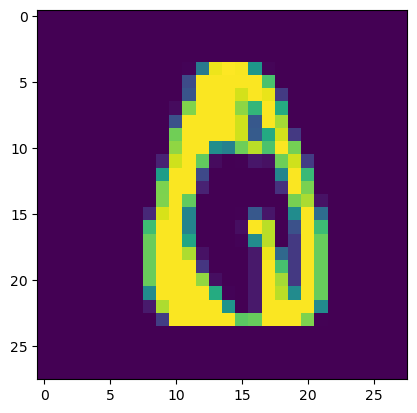

In [95]:
plt.imshow(test_images_regular_norm[np.argmax(mse_regular)])
plt.show()

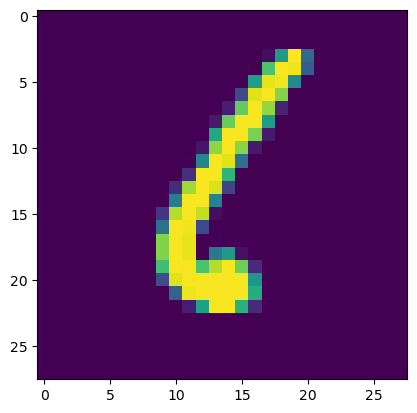

In [96]:
plt.imshow(test_images_outlier_norm[np.argmin(mse_outlier)])
plt.show()

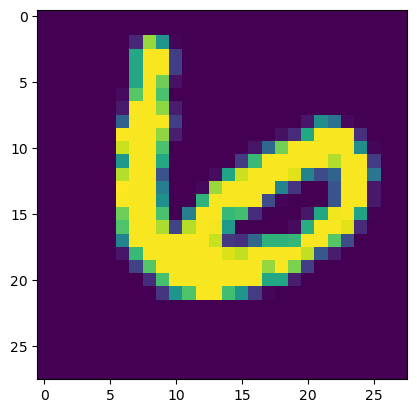

In [97]:
plt.imshow(test_images_outlier_norm[np.argmax(mse_outlier)])
plt.show()

### SSIM - structural similarity index measure [Higher is better]


In [98]:
def calc_ssim(true, pred, max_val=1.0):
    true = tf.cast(true, tf.float32)
    pred = tf.cast(pred, tf.float32)

    if len(true.shape) == 3:
        true = tf.expand_dims(true, -1)
    if len(pred.shape) == 3:
        pred = tf.expand_dims(pred, -1)
        
    if true.shape[3] > 1 and true.shape[1] == 1:
        true = tf.transpose(true, [0, 2, 3, 1])
    if pred.shape[3] > 1 and pred.shape[1] == 1:
        pred = tf.transpose(pred, [0, 2, 3, 1])
        
    ssim = []
    for i in range(true.shape[0]):
        ssim_score = tf.image.ssim(
            true[i : i + 1],
            pred[i : i + 1],
            max_val,  # maximum value for normalized images
        )
        ssim.append(ssim_score[0])

    return np.array(ssim)

In [99]:
ssim_regular = calc_ssim(test_images_regular_norm, reconstruction_loss_dense_regular)
ssim_outlier = calc_ssim(test_images_outlier_norm, reconstruction_loss_dense_outlier)

print(f"SSIM Regular:\n {ssim_regular[:ssim_outlier.shape[0]]}")
print("Min:", ssim_regular.min())
print("Max:", ssim_regular.max())
print()
print(f"SSIM Outlier:\n {ssim_outlier}")
print("Min:", ssim_outlier.min())
print("Max:", ssim_outlier.max())

SSIM Regular:
 [0.7868285  0.90730906 0.8910221  0.88807386 0.7050802  0.8768673
 0.898718   0.9314057  0.5688066  0.9497739  0.96703404 0.83477634
 0.9557757  0.9569678  0.93882877 0.9306678  0.9642735  0.95884705
 0.9464409  0.95329756 0.7606402  0.9551687  0.8779703  0.9182304
 0.9211246  0.86849356 0.90464836 0.91244024 0.9614871  0.856826
 0.9251295  0.8687375  0.91178113 0.9400711  0.9669904  0.8900904
 0.94235617 0.9738901  0.9554127  0.9549732  0.9468572  0.9225091
 0.8223391  0.95857453 0.9716726  0.92349017 0.9309343  0.7579292
 0.9475103  0.91686136]
Min: 0.44901755
Max: 0.9817328

SSIM Outlier:
 [0.55963236 0.7494394  0.6110177  0.6688483  0.66204596 0.61154824
 0.5634506  0.7314645  0.70386297 0.8333571  0.69959813 0.49202874
 0.43100002 0.49634826 0.7021136  0.6374511  0.58847535 0.76068705
 0.64426327 0.6525772  0.68035823 0.7913292  0.7226263  0.7366596
 0.6482577  0.6391353  0.62495005 0.6334539  0.6493395  0.38280722
 0.55123675 0.6325968  0.58645755 0.61044526 0.7009

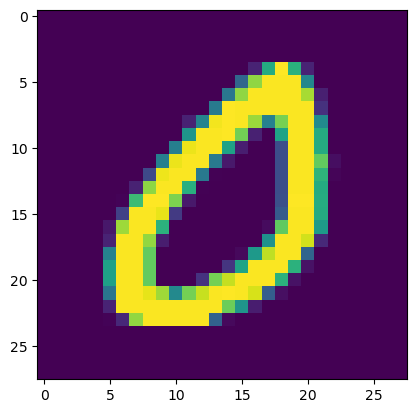

In [100]:
plt.imshow(test_images_regular_norm[np.argmax(ssim_regular)])
plt.show()

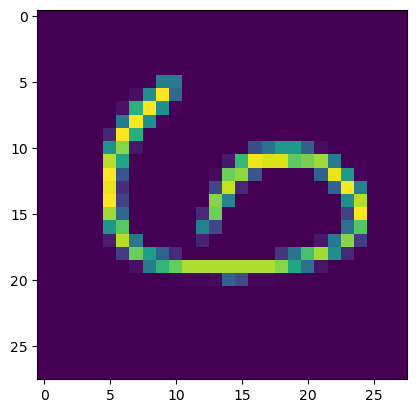

In [101]:
plt.imshow(test_images_outlier_norm[np.argmin(ssim_outlier)])
plt.show()

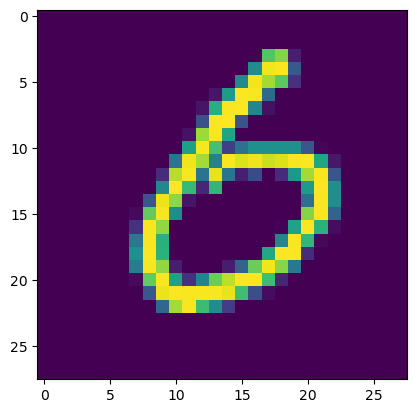

In [102]:
plt.imshow(test_images_outlier_norm[np.argmax(ssim_outlier)])
plt.show()

- It is noticed that because the MLP learns by hardcoding the approximate pixel locations of the digits, small changes in training affects the mse (max and min values) and ssim values resulting in inconsistencies in which digits it struggles to identify. 
- Also, it is clear when using SSIM that MLP is able to satisfactorily reconstruct images with very high SSIM >0.9 for most of the regular test images. Because "6" (outlier) and "0" (regular) are arguably similar looking, the SSIM score are not too bad >0.6 in most cases for "6"'s (outlier) but still distinguishable from the regular.

## Second Autoencoder - Conv


In [23]:
# Encoder
inp2 = tf.keras.layers.Input(shape=(train_images.shape[1], train_images.shape[2], 1))
x = tf.keras.layers.Rescaling(1 / 255.0)(inp2)
x = tf.keras.layers.Conv2D(14, (3, 3), strides=2, padding="same", activation="relu")(x)
x = tf.keras.layers.Conv2D(7, (3, 3), strides=2, padding="same", activation="relu")(x)
# x = tf.keras.layers.Conv2D(7, (3, 3), strides=2, padding="same", activation="relu")(x)

# Decoder
y = tf.keras.layers.Conv2DTranspose(
    7, (3, 3), strides=2, padding="same", activation="relu"
)(x)
# y = tf.keras.layers.Conv2DTranspose(
#     7, (3, 3), strides=2, padding="same", activation="relu"
# )(y)
y = tf.keras.layers.Conv2DTranspose(
    14, (3, 3), strides=2, padding="same", activation="relu"
)(y)
out2 = tf.keras.layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(y)


conv_autoencoder = tf.keras.Model(inp2, out2)

conv_autoencoder.compile(optimizer="adam", loss="mse")

conv_autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 14)     │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 7)        │           889 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 14, 14, 7)      │           448 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 14)     │           896 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 1)      │           127 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,500 (9.77 KB)

 Trainable params: 2,500 (9.77 KB)

 Non-trainable params: 0 (0.00 B)

### Training


In [ ]:
history = conv_autoencoder.fit(
    train_images_regular_norm,
    train_images_regular_norm,
    epochs=40,
    batch_size=64,
    validation_split=0.1,
)

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - loss: 0.1502 - val_loss: 0.1503
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 0.1506 - val_loss: 0.1503
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.1512 - val_loss: 0.1503
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.1513 - val_loss: 0.1503
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - loss: 0.1509 - val_loss: 0.1503
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.1511 - val_loss: 0.1503
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.1510 - val_loss: 0.1503
Epoch 8/40
21/88 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - loss: 0.1530

### Reconstruction Loss


In [54]:
reconstruction_loss_conv_outlier = conv_autoencoder.predict(test_images_outlier_norm)
reconstruction_loss_conv_regular = conv_autoencoder.predict(test_images_regular_norm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [55]:
mse_regular = calc_mse(test_images_regular_norm, reconstruction_loss_dense_regular)
mse_outlier = calc_mse(test_images_outlier_norm, reconstruction_loss_dense_outlier)

print(f"MSE Regular:\n {mse_regular[:mse_outlier.shape[0]]}")
print("Min:", mse_regular.min())
print("Max:", mse_regular.max())
print()
print(f"MSE Outlier:\n {mse_outlier}")
print("Min:", mse_outlier.min())
print("Max:", mse_outlier.max())

MSE Regular:
 [0.03155032 0.00917375 0.01339475 0.01292759 0.02153011 0.01426445
 0.01956667 0.0101134  0.03895469 0.01216317 0.00570684 0.01922264
 0.01031664 0.00661315 0.01137109 0.00796788 0.00583868 0.0107866
 0.01597452 0.01141654 0.03344316 0.00742071 0.01497964 0.01725281
 0.01219273 0.02080883 0.02172025 0.01542998 0.00957686 0.02015767
 0.01291373 0.01714482 0.01103699 0.01236343 0.00583901 0.01073709
 0.01071168 0.0035123  0.0068484  0.00723215 0.00888912 0.01229068
 0.01303109 0.00574325 0.00485575 0.01233955 0.01032155 0.03780579
 0.01022749 0.0113162 ]
Min: 0.0032785147716075653
Max: 0.045010181619605814

MSE Outlier:
 [0.04027531 0.02672636 0.03123169 0.02773516 0.02597593 0.04118616
 0.02578279 0.03981932 0.031086   0.03861148 0.03473276 0.04917434
 0.04426042 0.02721082 0.02304219 0.04130167 0.04421833 0.02933928
 0.04128365 0.05014847 0.03977945 0.03438099 0.02421866 0.02603478
 0.02214941 0.03268208 0.04045078 0.04428988 0.03588307 0.03085958
 0.03135975 0.03296751 0

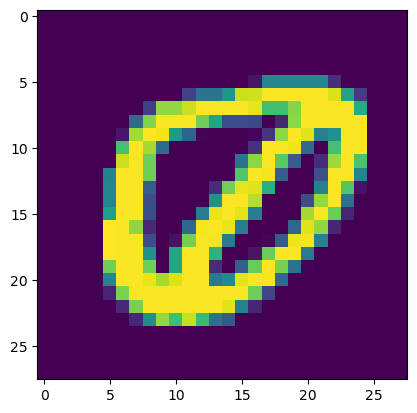

In [56]:
plt.imshow(test_images_regular_norm[np.argmax(mse_regular)])
plt.show()

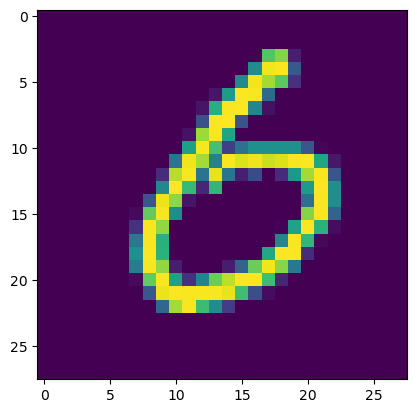

In [57]:
plt.imshow(test_images_outlier_norm[np.argmin(mse_outlier)])
plt.show()

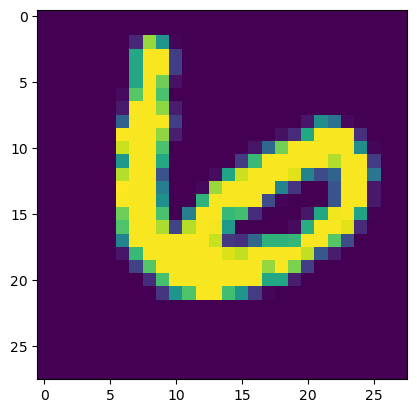

In [58]:
plt.imshow(test_images_outlier_norm[np.argmax(mse_outlier)])
plt.show()

### SSIM - structural similarity index measure


In [ ]:
ssim_regular = calc_ssim(test_images_regular_norm, reconstruction_loss_dense_regular)
ssim_outlier = calc_ssim(test_images_outlier_norm, reconstruction_loss_dense_outlier)

print(f"SSIM Regular:\n {ssim_regular[:ssim_outlier.shape[0]]}")
print("Min:", ssim_regular.min())
print("Max:", ssim_regular.max())
print()
print(f"SSIM Outlier:\n {ssim_outlier}")
print("Min:", ssim_outlier.min())
print("Max:", ssim_outlier.max())

## Convolutional Autoencoder - Second attempt


In [ ]:
# Encoder
inp2 = tf.keras.layers.Input(shape=(train_images.shape[1], train_images.shape[2], 1))
x = tf.keras.layers.Rescaling(1 / 255.0)(inp2)
x = tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
x = tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)  # 14x14
x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)  # 7x7
x = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)

# Decoder
y = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
y = tf.keras.layers.Conv2DTranspose(
    64, (3, 3), strides=2, padding="same", activation="relu"
)(y)
y = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(y)
y = tf.keras.layers.Conv2DTranspose(
    32, (3, 3), strides=2, padding="same", activation="relu"
)(y)
y = tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu")(y)
out2 = tf.keras.layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(y)


conv_autoencoder2 = tf.keras.Model(inp2, out2)

conv_autoencoder2.compile(optimizer="adam", loss="mse")

conv_autoencoder2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 14, 14, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 425,153 (1.62 MB)

 Trainable params: 425,153 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = conv_autoencoder2.fit(
    train_images_regular_norm,
    train_images_regular_norm,
    epochs=40,
    batch_size=64,
    validation_split=0.1,
)

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.1780 - val_loss: 0.1503
Epoch 2/40
72/88 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.1504

In [ ]:
reconstruction_loss_conv_outlier = conv_autoencoder2.predict(test_images_outlier_norm)
reconstruction_loss_conv_regular = conv_autoencoder2.predict(test_images_regular_norm)